# Figure 1 (and/or+ Supp Fig) : 

  - exemple of PSD in one subject (displaying 20s epochs)
  - exemple of PSD in one subject (displaying sensors)
  - 1/f for all subjects overlapped in 1 figure (1 line is one subject)
  - psd for all individuals in one or two shots


  - capture and picture variance in figure

We first need to download the requisite data. We are probablt on a "c3.2xlarge" instance, where the storage dir is in /mnt by my own convention.
We also make sure that all auxilliary files are in our working directory.
Depending on the kind of instance this type of downloading can take a moment. Might be worth having a coffee.

In [5]:
import glob
import os.path as op
import mne
import numpy as np
import matplotlib.pyplot as plt

In [1]:
%%bash
(cp ../*txt . && cp ../*csv .)

In [6]:
%%bash
for sub in $(cat hcp_good_subjects.txt); do
    echo "downloading epochs for ${sub}" 
    python hcp_compute_subject.py --storage_dir /mnt --hcp_no_anat --hcp_no_meg \
    --subject $sub --downloaders "library:downloaders.get_single_trial_psd";
done

Elapsed time downloading hcp-meg-data from s3 00:00:10
generating results dir
generated run id: 2016-04-27_14-28-53
preparing logging:
... making logging directory: /mnt/hcp-meg/100307/download_only/2016-04-27_14-28-53
... writing runtime info to: /mnt/hcp-meg/100307/download_only/2016-04-27_14-28-53/run_time.json
... logging source code of calling script
... No config found. Logging nothing.
... preparing Report
Embedding : jquery-1.10.2.min.js
Embedding : jquery-ui.min.js
Embedding : bootstrap.min.js
Embedding : jquery-ui.min.css
Embedding : bootstrap.min.css
... setting logfile: /mnt/hcp-meg/100307/download_only/2016-04-27_14-28-53/run_output.log
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 100307
downloading only
Elapsed time for running scripts 00:00:10
could not get hcp-meg/102816/psds-r0-0-150-epo.fif : it does not exist
could not get hcp-meg/102816/psds-r1-0-150-epo.fif : it does not exist
could not get hcp-meg

# Now that we have downloaded everything let's get the stuff into Python.

- What we then need to do in order to get the figures is to first compute grand averages and grand standard deviations per subject. 
- Then we can pick good examples of individual subjects. 
- Then we can compute total grand averages total grand standard deviation.
- Then we can look into 1/f stuff

In [3]:

recordings_path = '/mnt/hcp-meg'
pattern = 'psds-r{run}-0-150-epo.fif'
subjects = glob.glob(op.join(recordings_path, '??????'))

def get_epochs_for_subject(subject):
    epochs_list = list()
    for run_index in range(2):
        psd_fname = op.join(recordings_path, subject, pattern.format(run=run_index))
        if op.isfile(psd_fname):
            epochs = mne.read_epochs(psd_fname)
            if epochs.info['nchan'] == 248:
                epochs_list.append(epochs)
    if epochs_list:
        epochs = mne.epochs.concatenate_epochs(epochs_list)
    else:
        epochs = None
    return epochs

# mean first or log first?

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

epochs = get_epochs_for_subject(subjects[0])
X_std = np.log10(epochs.standard_error().data)
X2_std = np.log10(epochs.get_data()).std(0)
X = np.log10(epochs.average().data)
X2 = np.log10(epochs.get_data()).mean(0)

# multitaper does subsample, our actual frange is:
freqs = np.log10(np.linspace(0.001, 127, len(epochs.times)))

Reading /mnt/hcp-meg/250427/psds-r0-0-150-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   14997.22 ms (None)
        0 CTF compensation matrices available
12 matching events found
No baseline correction applied
12 matching events found
No baseline correction applied
0 projection items activated
Reading /mnt/hcp-meg/250427/psds-r1-0-150-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   14997.22 ms (None)
        0 CTF compensation matrices available
56 matching events found
No baseline correction applied
56 matching events found
No baseline correction applied
0 projection items activated
68 matching events found
No baseline correction applied
0 bad epochs dropped


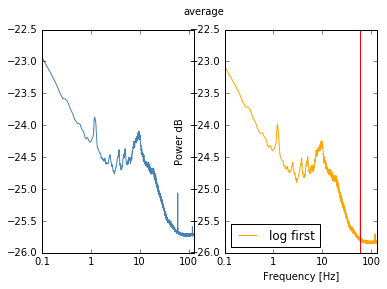

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True)
plt.suptitle('average')
axes[0].plot(freqs, X.mean(0), color='steelblue', label='average first')
axes[1].plot(freqs, X2.mean(0), color='orange', label='log first')
plt.axvline(np.log10(60), color='red')
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlim(np.log10([0.1, 130]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power dB')
plt.legend(loc='lower left')

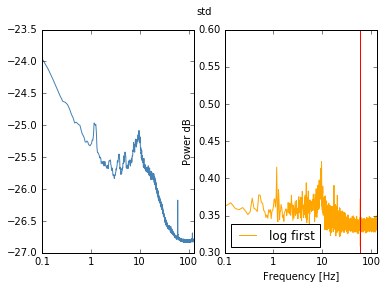

In [8]:
fig, axes = plt.subplots(1, 2, sharex=True)
plt.suptitle('std')
freqs = np.log10(np.linspace(0.001, 127, len(epochs.times)))
axes[0].plot(freqs, X_std.mean(0), color='steelblue', label='average first')
axes[1].plot(freqs, X2_std.mean(0), color='orange', label='log first')
plt.axvline(np.log10(60), color='red')
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlim(np.log10([0.1, 130]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power dB')
plt.legend(loc='lower left')

_Clearly, we want to first log, then aveage!_

In [16]:
# summarize our subjects
averages_std = list()
averages_mean = list()
subjects_psds = list()
for subject in subjects:
    epochs = get_epochs_for_subject(subject)
    if epochs is None:
        print('Cannot find data for %s' % subject)
        continue
    subjects_psds.append(subject)
    epochs._data = np.log10(epochs._data)
    averages_std.append(epochs.standard_error())
    averages_mean.append(epochs.average())

Reading /mnt/hcp-meg/250427/psds-r0-0-150-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   14997.22 ms (None)
        0 CTF compensation matrices available
12 matching events found
No baseline correction applied
12 matching events found
No baseline correction applied
0 projection items activated
Reading /mnt/hcp-meg/250427/psds-r1-0-150-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   14997.22 ms (None)
        0 CTF compensation matrices available
56 matching events found
No baseline correction applied
56 matching events found
No baseline correction applied
0 projection items activated
68 matching events found
No baseline correction applied
0 bad epochs dropped
Reading /mnt/hcp-meg/679770/psds-r0-0-150-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   14997.22 ms (None)
        0 CTF compensation matrices available
40 matching events found
No baseline correction

In [53]:
from scipy.stats import trim_mean

def tmean(X):
    return trim_mean(X, proportiontocut=0.1, axis=0)

viz_agg = dict(
    mean_mean=tmean([evoked.data for evoked in averages_mean]),
    std_mean=tmean([evoked.data for evoked in averages_std]),
    mean_std=np.std([evoked.data for evoked in averages_mean], axis=0),
    std_std=np.std([evoked.data for evoked in averages_std], axis=0))


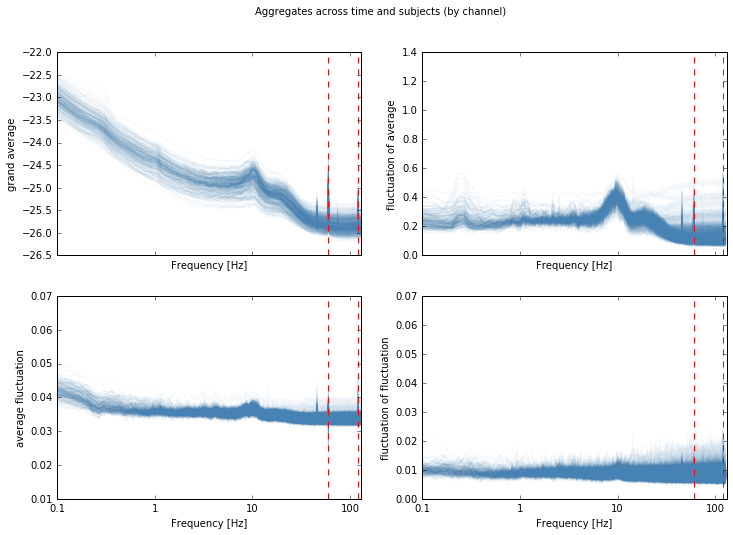

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle('Aggregates across time and subjects (by channel)')
keys = 'mean_mean', 'mean_std', 'std_mean', 'std_std'
for ii, (ax, key) in enumerate(zip(axes.ravel(), keys)):
    ax.plot(freqs, viz_agg[key].T, color='steelblue', alpha=0.05)
    for line in np.log10([60, 120]):
        ax.axvline(line, color='red', linestyle='--')
    ax.set_xticks(np.log10([0.1, 1, 10, 100]))
    ax.set_xticklabels([0.1, 1, 10, 100])
    ax.set_xlim(np.log10([0.1, 130]))
    ax.set_xlabel('Frequency [Hz]')
    if key == 'mean_mean':
        ax.set_ylabel('grand average')
    elif key == 'mean_std':
        ax.set_ylabel('fluctuation of average')
    elif key == 'std_mean':
        ax.set_ylabel('average fluctuation')
    elif key == 'std_std':
        ax.set_ylabel('fluctuation of fluctuation')
         

We see interestingly variability in alpha with any aggregation.

In [57]:
viz_agg_subjects = dict(
    mean_mean=np.array([tmean(evoked.data) for evoked in averages_mean]),
    std_mean=np.array([tmean(evoked.data) for evoked in averages_std]),
    mean_std=np.array([evoked.data.std(0) for evoked in averages_mean]),
    std_std=np.array([evoked.data.std(0) for evoked in averages_std]))


In [59]:
print(viz_agg_subjects['mean_mean'].shape)


(72, 3815)


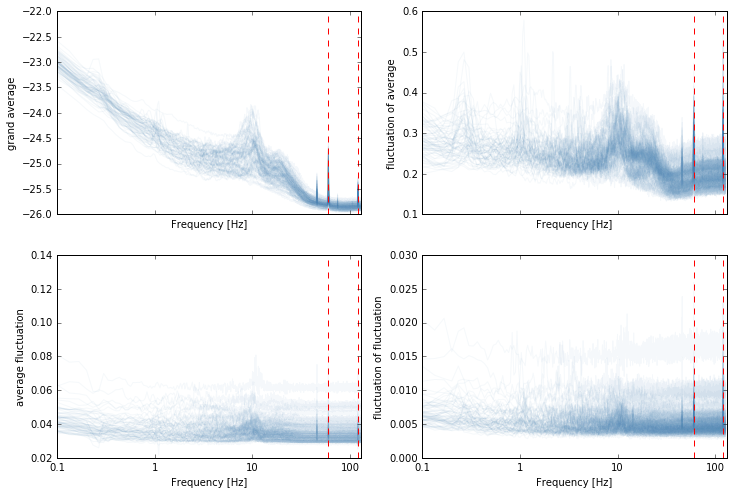

In [64]:
fix, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle('Aggregates across time and channel (by subject)')
keys = 'mean_mean', 'mean_std', 'std_mean', 'std_std'
for ii, (ax, key) in enumerate(zip(axes.ravel(), keys)):
    ax.plot(freqs, viz_agg_subjects[key].T, color='steelblue', alpha=0.05)
    for line in np.log10([60, 120]):
        ax.axvline(line, color='red', linestyle='--')
    ax.set_xticks(np.log10([0.1, 1, 10, 100]))
    ax.set_xticklabels([0.1, 1, 10, 100])
    ax.set_xlim(np.log10([0.1, 130]))
    ax.set_xlabel('Frequency [Hz]')
    if key == 'mean_mean':
        ax.set_ylabel('grand average')
    elif key == 'mean_std':
        ax.set_ylabel('fluctuation of average')
    elif key == 'std_mean':
        ax.set_ylabel('average fluctuation')
    elif key == 'std_std':
        ax.set_ylabel('fluctuation of fluctuation')

A similar pattern occurs when looking at the subject's distributions of cross-channel and cross-trial aggregates.

# 1/f estimation with residual or covariate analysis.

One particular problem of the correlation analysis between 1/f estimates and alpha power is related to the model fit. In other words what could drive the oscillations is not changes in 1/f per se but oscillations and low frequency fluctuations. To disentengle these contributing factors we propose to explicitly model both aspects using a regression model in which the actual 1/f fit and the residuals are taken into account when predicting the alpha power.
One intuitive way of achieving this is a second order regression model in which the coefficients and the model fit, e.g., measured as $R^{2}$ or $MSQ$ score as predictors of alpha.
